In [48]:
# import numpy as np
# np.random.seed(42)
# # Define the ReLU activation function and its derivative
# def relu(x):
#     return np.maximum(0, x)

# def relu_prime(x):
#     return (x > 0).astype(float)

# # Define the softmax activation function and its derivative
# def softmax(x):
#     exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
#     return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# def softmax_prime(x):
#     s = softmax(x)
#     return s * (1 - s)

# # Define a class for the neural network
# class NeuralNetwork:

#     # Initialize the network with the given parameters
#     def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.learning_rate = learning_rate

#         # Initialize the weights and biases randomly
#         #  Use He initialization for W1
#         self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
#         self.b1 = np.random.randn(hidden_size) * 0.01
#         # Use Xavier initialization for W2
#         x = np.sqrt(6 / (hidden_size + output_size))
#         self.W2 = np.random.uniform(-x, x, size=(hidden_size, output_size))
#         self.b2 = np.random.randn(output_size) * 0.01

#         # Initialize the loss function as cross-categorical entropy
#         self.loss = lambda y_true, y_pred: -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]
#         # Define the forward propagation method
#     def forward(self, X):
#         # Compute the hidden layer output
#         self.Z1 = X.dot(self.W1) + self.b1
#         self.A1 = relu(self.Z1)

#         # Compute the output layer output
#         self.Z2 = self.A1.dot(self.W2) + self.b2
#         self.A2 = softmax(self.Z2)

#         # Return the output probabilities
#         return self.A2
#         # Define the backward propagation method
#     def backward(self, X, y):
#         print(X.shape[0])
#         # Compute the output layer error
#         self.dZ2 = self.A2 - y

#         # Compute the output layer gradients
#         self.dW2 = self.A1.T.dot(self.dZ2) / X.shape[0]
#         self.db2 = np.sum(self.dZ2, axis=0) / X.shape[0]

#         # Compute the hidden layer error
#         self.dA1 = self.dZ2.dot(self.W2.T)
#         self.dZ1 = self.dA1 * relu_prime(self.Z1)

#         # Compute the hidden layer gradients
#         self.dW1 = X.T.dot(self.dZ1) / X.shape[0]
#         self.db1 = np.sum(self.dZ1, axis=0) / X.shape[0]

#         # Update the weights and biases using the learning rate
#         self.W1 -= self.learning_rate * self.dW1
#         self.b1 -= self.learning_rate * self.db1
#         self.W2 -= self.learning_rate * self.dW2
#         self.b2 -= self.learning_rate * self.db2
#         # Define the training method
#     def train(self, X, y, epochs):
#         # Loop over the number of epochs
#         batch_size = 32
#         losses = []
#         accuracies = []
#         for epoch in range(epochs):
#             # Shuffle the data and split it into batches
#             permutation = np.random.permutation(X.shape[0])
#             X = X[permutation]
#             y = y[permutation]
#             n_batches = X.shape[0] // batch_size
#             # Loop over the batches
#             for i in range(n_batches):
#                 # Get the current batch
#                 X_batch = X[i * batch_size : (i + 1) * batch_size]
#                 y_batch = y[i * batch_size : (i + 1) * batch_size]
#                 # Perform the forward propagation
#                 y_pred = self.forward(X_batch)

#                 # Perform the backward propagation
#                 self.backward(X_batch, y_batch)

#             # Compute the loss and the accuracy on the whole data
#             y_pred = self.forward(X)
#             loss = self.loss(y, y_pred)
#             accuracy = np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
#             losses.append(loss)
#             accuracies.append(accuracy)
#             # Print the loss and the accuracy
#             print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
#         return losses, accuracies
        
            
            



In [83]:
import numpy as np

np.random.seed(42)

# Define the ReLU activation function and its derivative
def relu(x):
    return np.maximum(0, x)

def relu_prime(x):
    return (x > 0).astype(float)

# Define the softmax activation function and its derivative
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_prime(x):
    s = softmax(x)
    return s * (1 - s)

# Define a class for the input layer
class InputLayer:
    def __init__(self, input_size):
        self.input_size = input_size

class HiddenLayer:
    def __init__(self, input_size, hidden_size, activation=relu, activation_prime=relu_prime):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation = activation
        self.activation_prime = activation_prime
        self.W = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b = np.random.randn(hidden_size) * 0.01

    def forward(self, X):
        self.Z = X.dot(self.W) + self.b
        self.A = self.activation(self.Z)
        return self.A

    def backward(self, X, dA):
        if self.activation_prime == softmax_prime:  # output layer
            self.dZ = dA
        else:  # hidden layer
            self.dZ = dA * self.activation_prime(self.Z)
        self.dW = X.T.dot(self.dZ) / X.shape[0]
        self.db = np.sum(self.dZ, axis=0) / X.shape[0]
        self.dX = self.dZ.dot(self.W.T)
        return self.dX

    def update(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db


# Define a class for the neural network
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.input_layer = InputLayer(input_size)
        self.hidden_layer = HiddenLayer(input_size, hidden_size)
        self.output_layer = HiddenLayer(hidden_size, output_size, activation=softmax, activation_prime=softmax_prime)
        self.learning_rate = learning_rate
        self.loss = lambda y_true, y_pred: -np.sum(y_true * np.log(y_pred + 1e-9)) / y_true.shape[0]

    def forward(self, X):
        A1 = self.hidden_layer.forward(X)
        A2 = self.output_layer.forward(A1)
        return A2

    def backward(self, X, y):
        dA2 = self.output_layer.A - y
        dA1 = self.output_layer.backward(self.hidden_layer.A, dA2)
        self.hidden_layer.backward(X, dA1)

    def update(self):
        self.hidden_layer.update(self.learning_rate)
        self.output_layer.update(self.learning_rate)

    def train(self, X, y, epochs):
        batch_size = 32
        accuracies = []
        losses = []
        for epoch in range(epochs):
            permutation = np.random.permutation(X.shape[0])
            X = X[permutation]
            y = y[permutation]
            n_batches = X.shape[0] // batch_size
            for i in range(n_batches):
                X_batch = X[i * batch_size : (i + 1) * batch_size]
                y_batch = y[i * batch_size : (i + 1) * batch_size]
                y_pred = self.forward(X_batch)
                self.backward(X_batch, y_batch)
                self.update()
            y_pred = self.forward(X)
            loss = self.loss(y, y_pred)
            accuracy = np.mean(np.argmax(y, axis=1) == np.argmax(y_pred, axis=1))
            accuracies.append(accuracy)
            losses.append(loss)
            print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        return losses, accuracies

In [84]:
def normalize(data, i):
    # Initialize a list to store the means of each column
    means = [0] * i
    # Initialize a list to store the standard deviations of each column
    stds = [1] * i
    # Loop through the columns
    for j in range(i):
        # Compute the mean of the column
        mean = data.iloc[:, j].mean()
        # Compute the standard deviation of the column
        std = data.iloc[:, j].std()
        # Store the mean and standard deviation
        means[j] = mean
        stds[j] = std
    # Loop through the rows
    for index, row in data.iterrows():
        # Loop through the columns
        for j in range(i):
            # Normalize the value by subtracting the mean and dividing by the standard deviation
            row[j] = (row[j] - means[j]) / stds[j]
    # Return the normalized data
    return data
import pandas as pd
import numpy as np
df = pd.read_csv('Acoustic Features.csv')
# drop duplicate
df = df.drop_duplicates(keep='first')
# Split feature and target
X = df.drop(columns=['Class'])
y = df['Class']
X = normalize(X,50)
y = pd.get_dummies(y, columns = ['Class'])


Epoch 1, Loss: 1.2313, Accuracy: 0.4768
Epoch 2, Loss: 1.0595, Accuracy: 0.5644
Epoch 3, Loss: 0.9401, Accuracy: 0.6340
Epoch 4, Loss: 0.8503, Accuracy: 0.6959
Epoch 5, Loss: 0.7572, Accuracy: 0.7242
Epoch 6, Loss: 0.6843, Accuracy: 0.7603
Epoch 7, Loss: 0.6170, Accuracy: 0.7990
Epoch 8, Loss: 0.5567, Accuracy: 0.8093
Epoch 9, Loss: 0.5107, Accuracy: 0.8144
Epoch 10, Loss: 0.4720, Accuracy: 0.8402
Epoch 11, Loss: 0.4405, Accuracy: 0.8505
Epoch 12, Loss: 0.4141, Accuracy: 0.8660
Epoch 13, Loss: 0.3906, Accuracy: 0.8686
Epoch 14, Loss: 0.3693, Accuracy: 0.8789
Epoch 15, Loss: 0.3524, Accuracy: 0.8840
Epoch 16, Loss: 0.3333, Accuracy: 0.8814
Epoch 17, Loss: 0.3207, Accuracy: 0.8892
Epoch 18, Loss: 0.3051, Accuracy: 0.8995
Epoch 19, Loss: 0.2921, Accuracy: 0.8969
Epoch 20, Loss: 0.2811, Accuracy: 0.8969
Epoch 21, Loss: 0.2705, Accuracy: 0.9072
Epoch 22, Loss: 0.2607, Accuracy: 0.9098
Epoch 23, Loss: 0.2522, Accuracy: 0.9201
Epoch 24, Loss: 0.2431, Accuracy: 0.9304
Epoch 25, Loss: 0.2353, A

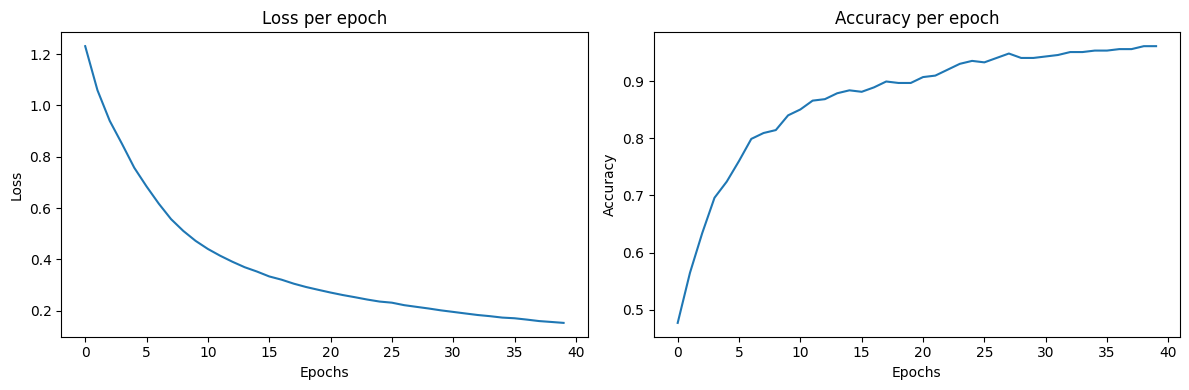

In [93]:

import matplotlib.pyplot as plt
# Create an instance of the neural network with 10 input features, 5 hidden units, and 3 output classes
nn = NeuralNetwork(X.shape[1], 8, y.shape[1], 0.1)

# Train the neural network for 20 epochs
losses , accuracies = nn.train(X.to_numpy(), y.to_numpy(), 40)

# Plotting the loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Loss per epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Accuracy per epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()